# Demo: SVM for MNIST Digit Recognition

In this demo, you will learn to:
* Load and display images
* Formulate image classification problems
* Explain the limitations of linear classifiers for image classification
* Build a simple SVM image classifier 
* Save and load results using `pickle`.

For data, we will use the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data set used to recognize hand-written digits.  The dataset was originally produced in the 1980s and is now widely-used in machine learning classes as a simple image classification problem.  

## Loading the Data

First, we load the standard packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import linear_model, preprocessing

Since the MNIST dataset is so widely-used, it can be accessed using `sklearn`. Note that it may take a few minutes to load.

In [2]:
from sklearn import datasets

mnist = datasets.fetch_openml('mnist_784', version=1, cache=True)
mnist.data.shape

# Convert data to a matrix
X = np.array(mnist.data)
y = np.array(mnist.target.astype(np.int8)) # fetch_openml() returns targets as strings

/Users/brianlesko/Documents/VSCode/Machine_Learning/virtualmachine/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


There are 70000 images.  Each image is `28 x 28`, which is stored as a 784 pixel row vector.  The following code plots a digit.  To do this, it reshapes the vector into a `28 x 28` array and then uses the `plt.imshow` command.  

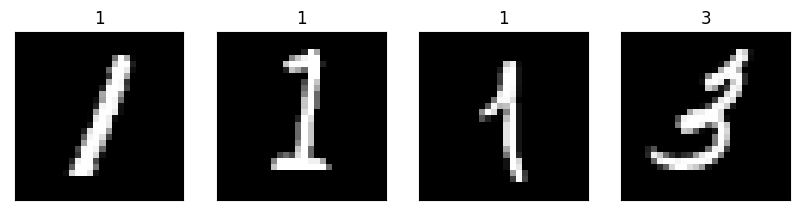

In [3]:
def plt_digit(x,y=None):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])    
    if y != None:
        plt.title('%d' % y)        

# Select random digits
nplt = 4
nsamp = X.shape[0]
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
plt.figure(figsize=(10,20))
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(1,nplt,i+1)
    plt_digit(X[ind,:], y[ind])    

## Classification via Logistic Regression

To classify the digits, we will first use logistic regression.  To speed things up, we will use only 10000 training and 10000 testing samples.  The performance would be a bit better with more training samples, but it would take longer to train.

In [4]:
ntr = 10000
nts = 10000
Xs = X/255.0*2 - 1 # convert to range [-1,1]
# careful: 2*X/255.0 will fail if X is uint8
Xtr = Xs[Iperm[:ntr],:]
ytr = y[Iperm[:ntr]]
Xts = Xs[Iperm[ntr:ntr+nts],:]
yts = y[Iperm[ntr:ntr+nts]]

Now we run the optimizer.  We'll use the `verbose=1` option to track its progress.  It should appear in the command line where you launched the jupyter notebook.  This can take several minutes and will likely report that it ran out of iterations.

In [5]:
logreg = linear_model.LogisticRegression(verbose=1, multi_class='multinomial', 
                                         solver='lbfgs', max_iter=500, C=1e-2)
logreg.fit(Xtr,ytr)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7850     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+04    |proj g|=  1.15811D+03

At iterate   50    f=  3.77829D+03    |proj g|=  1.52289D+01

At iterate  100    f=  3.74120D+03    |proj g|=  1.91931D+00

At iterate  150    f=  3.74060D+03    |proj g|=  1.61760D+00

At iterate  200    f=  3.73923D+03    |proj g|=  6.11619D+00

At iterate  250    f=  3.72700D+03    |proj g|=  3.57702D+00

At iterate  300    f=  3.72470D+03    |proj g|=  6.42761D-01

At iterate  350    f=  3.72467D+03    |proj g|=  1.20991D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s finished


LogisticRegression(C=0.01, max_iter=500, multi_class='multinomial', verbose=1)

Since it takes a while to run the optimizer, we'll save the results in a file.  You can use the `pickle` module for this purpose.

In [7]:
import pickle

with open( "mnist_logreg.p", "wb" ) as fp:
    pickle.dump( [logreg, X, y, Iperm],  fp)

Then, we can recover the objects via the `pickle.load` command

In [8]:
with open( "mnist_logreg.p", "rb" ) as fp:
    logreg, X, y, Iperm = pickle.load(fp)

Now, we will measure the accuracy on the test data.

In [9]:
yhat = logreg.predict(Xts)
acc = np.mean(yhat == yts)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.911300


You should get an accuracy of around 90%.  This may sound OK, but it is actually not that great on this dataset.  Had we used more training samples, we could have improved it to about 92%, but that is still far from state-of-the-art.  To illustrate, let's plot some of the errors.  

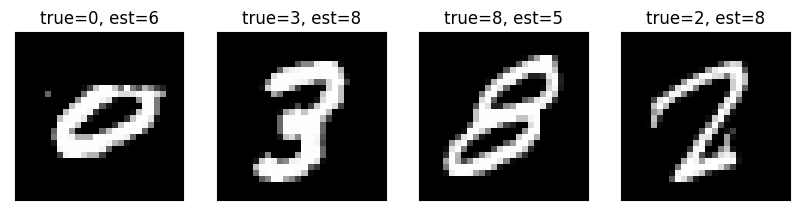

In [10]:
nplt = 4
Ierr = np.where(yts != yhat)[0]

plt.figure(figsize=(10, 4))
for i in range(nplt):        
    plt.subplot(1,nplt,i+1)        
    ind = Ierr[i]    
    plt_digit(Xts[ind,:])        
    title = 'true={0:d}, est={1:d}'.format(yts[ind].astype(int), yhat[ind].astype(int))
    plt.title(title)

These misclassified digits would not be too difficult for a human to classify correctly.  We can get a more detailed analysis of the errors by computing the confusion matrix.

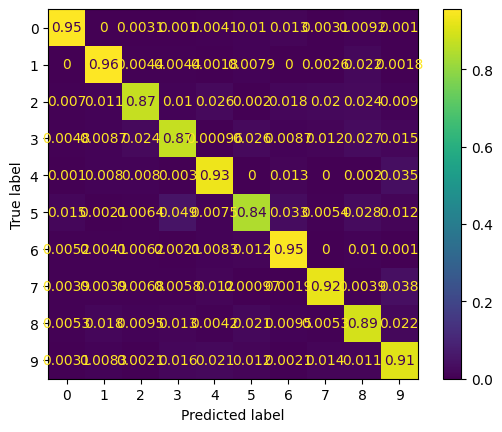

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
C = confusion_matrix(yts,yhat,normalize='true') # each row sums to one

# Print the confusion matrix
disp = ConfusionMatrixDisplay(C)
disp.plot();

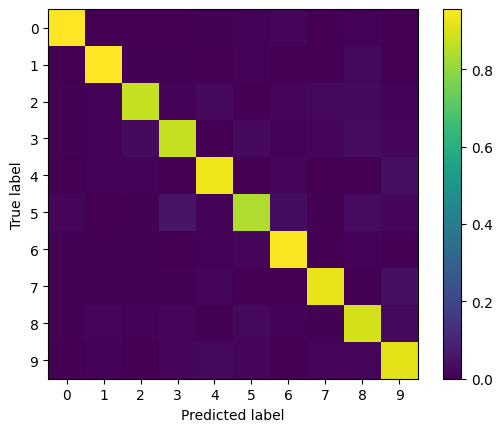

In [12]:
# Print the confusion matrix without the labels, which are difficult to read in this case
disp = ConfusionMatrixDisplay(C)
disp.plot(include_values=False);

### Visualizing the Weights

To better understand why the logistic classifier is failing, let's plot the weights for each digit.  

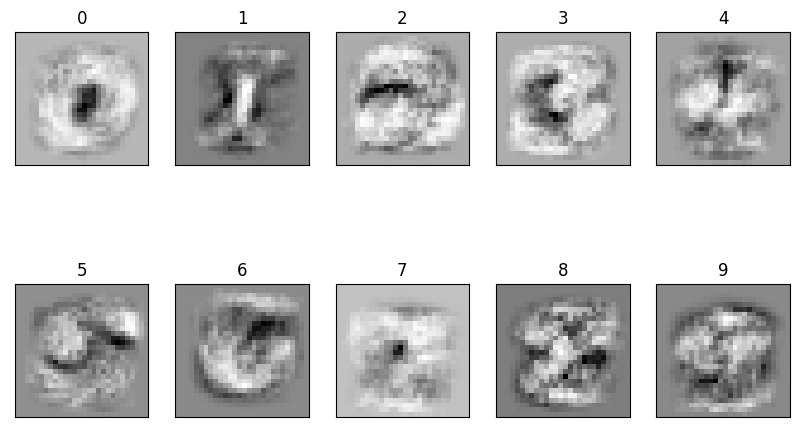

In [13]:
W = logreg.coef_
nlabel = W.shape[0]
plt.figure(figsize=(10, 6))
for i in range(nlabel):
    plt.subplot(2,5,i+1)
    plt_digit(W[i,:])
    plt.title('{0:d}'.format(i))

We see that each weight matrix is a very blurry version of each digit.  The blurriness is due to the fact each weight matrix must correlate well with all shifts, rotations, and other variations of each digit.  As a result, each weight begins to correlate with other digits than the intended one, leading to poor classification performance.

## Classification with SVC (i.e., SVM with linear kernel)

First we import the SVM package.  Then we construct the SVC.  We have two choices here: we could use svm.SVC with kernel="linear", but a faster option is to use svm.LinearSVC (which only works with the linear kernel)

In [14]:
from sklearn import svm
# Create a classifier: a support vector classifier with linear kernel
svc = svm.LinearSVC(loss='hinge', C=1e-2, multi_class='crammer_singer', verbose=1)

Above, the value of 'C' above was manually tuned to give decent performance.  Note also that we are using the Crammer-Singer approach, which jointly trains the biases and weight vectors, and which performs a bit better than the OVR approach here.  Finally, by setting loss='hinge' we get the standard SVC approach described in the lecture.

Next we fit the SVC parameters.  Depending on the value of C, this could take several minutes, so we'll save the results in a pickle file.

In [15]:
# Skip this step if you want to load from a saved result 
svc.fit(Xtr,ytr)
with open( "mnist_svc.p", "wb" ) as fp:
    pickle.dump( [svc, Xtr, ytr, Xts, yts], fp)

[LibLinear]..*...*..*.....*.....*.......*...........*.............*.................*............*.......................*.....................*.......................*....................*........*
optimization finished, #iter = 1725
Objective value = -20.201558
nSV = 8741


/Users/brianlesko/Documents/VSCode/Machine_Learning/virtualmachine/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [15]:
# You can skip this step if you just trained the SVC
with open( "mnist_svc.p", "rb" ) as fp:
    svc, Xtr, ytr, Xts, yts = pickle.load(fp)

Now we'll predict the test labels.

In [16]:
yhat_ts = svc.predict(Xts)

Finally we'll measure accuracy on the test data

In [17]:
acc = np.mean(yhat_ts == yts)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.915100


You should get an accuracy of around 91%.  This is better than logistic regression.  But we can still do much better with a different kernel.

## Classification via SVM with the RBF kernel

We now try an SVM based on the RBF kernel.  We'll use the parameters from 

https://martin-thoma.com/svm-with-sklearn/

This website has a nice summary of the main equations for SVM as well.

First we set up the classifer.  For this, we'll use svm.SVC, because svm.LinearSVC does not allow us to use a kernel!

In [18]:
# Create a classifier: a support vector classifier with RBF kernel
svm = svm.SVC(probability=False, kernel="rbf", C=2.8, gamma=.0073, verbose=1)

Now we train the SVM.  This might take several minutes, so we'll save the results.

In [19]:
# Skip this step if you want to load from a saved result 
svm.fit(Xtr,ytr)
with open( "mnist_svm.p", "wb" ) as fp:
    pickle.dump( [svm, Xtr, ytr, Xts, yts], fp)

[LibSVM]*
optimization finished, #iter = 370
obj = -23.868915, rho = -0.687782
nSV = 215, nBSV = 0
*
optimization finished, #iter = 942
obj = -86.946326, rho = 0.169641
nSV = 523, nBSV = 0
*
optimization finished, #iter = 868
obj = -75.365220, rho = 0.062407
nSV = 487, nBSV = 0
*
optimization finished, #iter = 746
obj = -53.856970, rho = -0.135585
nSV = 424, nBSV = 0
*.*
optimization finished, #iter = 1026
obj = -93.850515, rho = 0.083699
nSV = 560, nBSV = 0
*
optimization finished, #iter = 829
obj = -84.407068, rho = -0.124444
nSV = 434, nBSV = 0
*
optimization finished, #iter = 741
obj = -57.287551, rho = -0.145327
nSV = 406, nBSV = 0
*
optimization finished, #iter = 937
obj = -77.885894, rho = 0.066879
nSV = 525, nBSV = 0
*
optimization finished, #iter = 763
obj = -62.831514, rho = -0.198734
nSV = 417, nBSV = 0
*
optimization finished, #iter = 535
obj = -58.888173, rho = 0.966829
nSV = 259, nBSV = 1
*
optimization finished, #iter = 530
obj = -54.381296, rho = 0.802059
nSV = 262, nBS

In [20]:
# You can skip this step if you just trained the SVM
with open( "mnist_svm.p", "rb" ) as fp:
    svm, Xtr, ytr, Xts, yts = pickle.load(fp)

Now we generate the SVM prediction.  The prediction can take several minutes, too, so we'll save the results. Relative to today's state-of-the-art methods, SVMs are very slow! 

In [20]:
# Skip this step if you want to load from a saved result 
yhat_ts = svm.predict(Xts)
with open("mnist_svm_test.p", "wb") as fp:
    pickle.dump([yts,yhat_ts,Xts], fp)

In [22]:
# You can skip this step if you just ran the SVM prediction
with open("mnist_svm_test.p", "rb") as fp:
    yts,yhat_ts,Xts = pickle.load(fp)

Finally we compute the accuracy.

In [21]:
acc = np.mean(yhat_ts == yts)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.969800


You should see around 97% accuracy.  This is much better than with a linear kernel (i.e., SVC)!  And if we had used 50000 training samples, we could get close to 98.5% accuracy.
Now let's plot some errors.

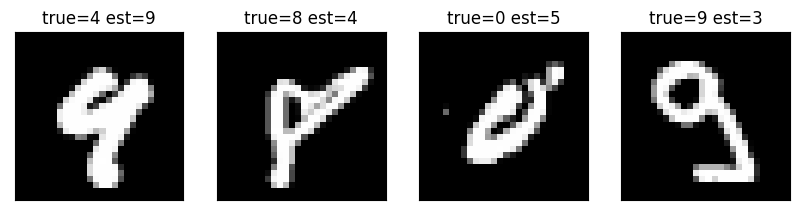

In [26]:
Ierr = np.where((yhat_ts != yts))[0]
nplt = 4
plt.figure(figsize=(10, 4))
for i in range(nplt):        
    plt.subplot(1,nplt,i+1)        
    ind = Ierr[i]    
    plt_digit(Xts[ind,:])        
    title = 'true={0:d} est={1:d}'.format(yts[ind].astype(int), yhat_ts[ind].astype(int))
    plt.title(title) 

Again, a human would probably not have made these errors, but still these examples are more difficult to classify than the ones that logistic regression got wrong.

### Visualizing the Support Vectors

Now let's examine the support vectors.  First, we notice that there about 5000 of them.  So, about half the training samples were used as SVs, which is more than those used by the linear kernel.  This is partly why the prediction was so slow.

In [27]:
S = svm.support_vectors_
S.shape

(4902, 784)

Finally, let's visualize some support vectors.

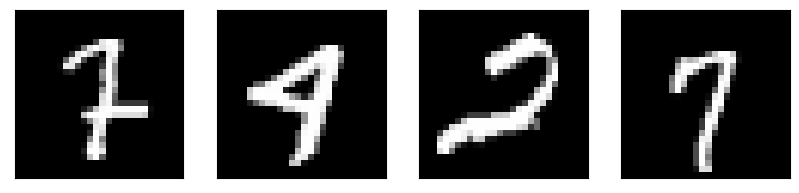

In [33]:
nplt = 4
nsv = S.shape[0]
Iperms = np.random.permutation(nsv)
plt.figure(figsize=(10, 4))
for i in range(nplt):        
    plt.subplot(1,nplt,i+1)        
    ind = Iperms[i]
    plt_digit(S[ind,:])        

We see that the support vectors look like digits that might be misclassified.

In this demo, we hard-coded the parameters of the SVM. In the lab, you will be asked to optimize the parameters through cross validation.